### 数据预处理

In [1]:
# 载入程序包
library(stringr)
library(ggplot2)
library(wordcloud2)
library(jiebaR)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: jiebaRD


In [2]:
# 读入数据
data <- read.csv('data.csv',
                 header = FALSE,
                 col.names = c("User", "URL", "Date", "Comment", 
                               "Rating", "Recommendation"),
                 colClasses = c("character", "character", "Date",
                                "character", "factor", "integer"))

In [3]:
# 缺失值查验
sum(apply(data, 2, is.na))
# 去除无用的因子
data <- subset(data, Rating != "")

[1] 0

In [4]:
# data format
str(data)

'data.frame':	498 obs. of  6 variables:
 $ User          : chr  "王大根" "李阿斗" "光明小卖部" "同志亦凡人中文站" ...
 $ URL           : chr  "https://www.douban.com/people/diewithme/" "https://www.douban.com/people/gailsylee/" "https://www.douban.com/people/gooooooooooohe/" "https://www.douban.com/people/3540441/" ...
 $ Date          : Date, format: "2018-01-19" "2017-11-25" ...
 $ Comment       : chr  " 在这种家庭里做一条狗都好啊\\\n        " " 当时出国以后的第一最大感受就是尊重，不论老弱病孕还是任何“与众不同”，都不会有人上下打量你。我不能说他们内心是否"| __truncated__ " 所有人都知道是化妆只有我一个人以为请的真实病人出演吗。。。\\\n        " " 有种糖放多了的感觉，精华基本都在预告里了。但对孩子们的纯真友情毫无抵抗力啊，就像被温柔的抚摸了一下软肋。Jacob "| __truncated__ ...
 $ Rating        : Factor w/ 6 levels "","力荐","很差",..: 2 2 2 4 4 6 6 2 2 4 ...
 $ Recommendation: int  6443 3414 3339 1811 1701 1210 1448 1391 1211 1056 ...


### 评论分析

#### 评论字数分析
长评与短评与推荐与否。

In [5]:
# 去除多余的标点符号，计算评论字数
clean_string <- function (string){
  return(gsub("[\\，\\.\\。\\\r\n\ ]", "", string))
}
data$Comment <- sapply(data$Comment, clean_string)
data$words <- sapply(data$Comment, nchar)

In [6]:
# 中心测度： 平均数，中位数
mean(data$words)
median(data$words)

[1] 63.40161

[1] 52.5

In [7]:
# 散布： 极差， 方差， 标准差， 分位数 
range(data$words)
var(data$words)
sd(data$words)
quantile(data$words)

[1]   2 217

[1] 1951.283

[1] 44.17333

0%    25%    50%    75%   100% 
  2.00  24.00  52.50 101.75 217.00

可以看出，评论的字数总体偏短，75%的评论在100字以内，且其中50%的评论在50词以内。

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


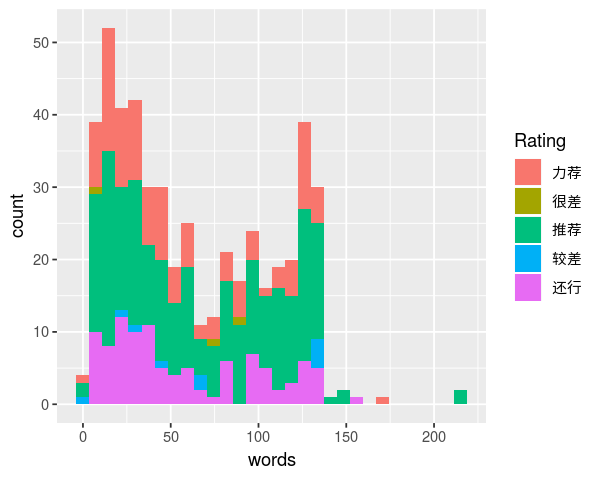

In [8]:
# 直方图
options(repr.plot.width=5, repr.plot.height=4)  # plot size
words <- ggplot(data, aes(fill=Rating, x=words))
words + geom_bar(stat = 'bin')

在看出总体评论字数偏少的峰同时，观察到另外一个字数较多的峰，且多为较好的评价（还行，推荐和力荐占据了绝大部分）。可以看出相当一部分喜欢这部电影的观众在写影评上还是下了一定的功夫的。

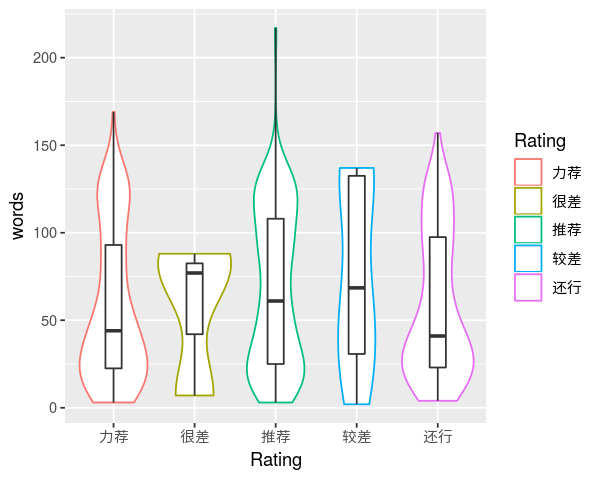

In [9]:
# 小提琴图
words <- ggplot(data, aes(x=Rating, y=words))
words + geom_violin(aes(color=Rating)) +
        geom_boxplot(width=0.2)

进一步地，我们综合之前的分位数等统计量，加上核密度估计给出评论字数的小提琴图(violin plot)， 据此可以更加清晰的看出不同观众群体的评论情况。可以看到比较有趣的一点，那就是对本电影评价为“很差”的观众，其评论字数的中位数是最大的。考虑到较大的极差，中位数比均值更加具有说福利，我们有理由认为那些对电影评价不好观众在极力地表达自己的观点:-)

In [10]:
# 词云图
wk = worker(stop_word = 'stopwords-zh.txt')
comment_freq <- as.data.frame(table(wk[data$Comment]))
comment_freq_sorted <- comment_freq[sort(comment_freq$Freq, decreasing = TRUE, 
                                         index.return=TRUE)$ix,]
top500 <- head(comment_freq_sorted, 500)
wordcloud2(top500)

HTML widgets cannot be represented in plain text (need html)

>这里好像不能正常显示，见pics文件夹下文件。

### 点赞走势

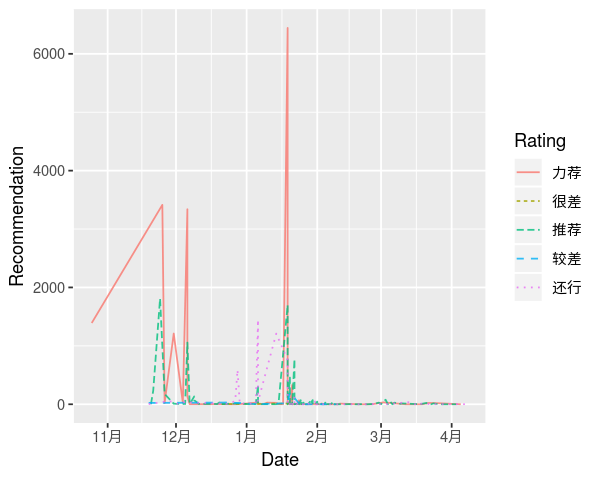

In [11]:
support <- ggplot(data, aes(x=Date, y=Recommendation,
                            color=Rating)) +
           geom_line(aes(linetype=Rating), alpha=0.8)
support

可以看到点赞的几个峰值均出现在“力荐”和“推荐”这里,表明主流的评价还是偏向好的一面。